In [309]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import missingno as msno
import matplotlib.pyplot as plt

## Intro to dataset 

What is the problem? For loan provider it is important to ensure that people who get the loan can make the payment and don't default, however it is equally important that people are not denied a loan due to a model trained on poor quality data. This is where data centric approach helps to make world a better place, as it provides a framework for data scientists and data engineers to question the quality of data. 

For this chapter we will use the loan default dataset from kaggle

We will first dive into data consistency, checking if column names are in a standard format and column values are consistent

We will read the data using pandas `read_csv` method

In [310]:
# Reading the data
df = pd.read_csv('train_loan_prediction.csv')

"""Lets check the first 5 rows of the dataset. By adding the T at the end the column names will be represented as rows 
and the first 5 rows will be represented as columns"""
df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


We can see some inconsistencies across column names `approv_in_adv` is all lower case `Credit_Worthiness` is upper case. `co-applicant_credit_type` column is using combination of `-` and `_`. This indicates column names have inconsistent naming conventions. Within the data we can also see some categorical columns have data in upper case, some have in camel case and some in lower case. For example `Gender` column has data in camel case, where the first letter is Upper and remaining characters are lower, where as in column `credit_type` all values are upper case. Sometimes we can have inconsistencies within the same column. What happens if gender column has two distinct values for male customers, `Male` and `male`. If we don't treat this, then our machine learning model will consider `male` data points separate to `Male`, and the model will not get an accurate signal.

In the next steps we will extract the list of column names of the data and make them all lower case, and ensure words will be separated by a unique character `_`. We shall also go through the data values of categorical columns and make them all lower case, and replace all the special characters with `_` and make our data consistent.


In [311]:
#Getting the column names
column_names = [cols for cols in df]
print(column_names)

['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [312]:
# We will now update the column names by adding underscore in long column names
df = df.rename(columns={'ApplicantIncome':'Applicant_Income', 
                        "CoapplicantIncome":"Co_Application_Income", 
                        "LoanAmount":"Loan_Amount"}
              )

In [313]:
# We will now make all columns lower case and in the next step update the columns
print([cols.lower() for cols in df])

['loan_id', 'gender', 'married', 'dependents', 'education', 'self_employed', 'applicant_income', 'co_application_income', 'loan_amount', 'loan_amount_term', 'credit_history', 'property_area', 'loan_status']


In [314]:
# Putting it together and updating the column names
df.columns = [cols.lower() for cols in df]
print(df.columns)

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicant_income', 'co_application_income',
       'loan_amount', 'loan_amount_term', 'credit_history', 'property_area',
       'loan_status'],
      dtype='object')


Within the data we can also see some categorical columns have data in in camel case and some data is separated by spaces and other times is separated by underscores. For instance `Gender` column has data in camel case, where the first letter is Upper and remaining characters are lower. Sometimes we can have inconsistencies within the same column. What happens if gender column has two distinct values for male customers, `Male` and `male`. If we don't treat this, then our machine learning model will consider `male` data points separate to `Male`, and the model will not get an accurate signal. We also have a education column, where data value of `Not Graduate` is separated by space. To ensure data consitency we must convert all data to lower case and replace spaces with underscores

In [315]:
# We will first extract the id column and the target column
id_col = 'loan_id'
target = 'loan_status'

We can see that `credit_history` column is encoded as numerical but has only two values where 1.0 means credit history meets guidelines and 0.0 means credit history doesnt meet guidelines. We should map these values to categorical column and change 1.0 to `yes` and 0.0 to `no`.

We can also see that `loan_amount_term` has discrete values, rather than continuous values. We can convert this data to string

In [316]:
df.credit_history = df.credit_history.map({
    1.0: 'yes',
    0.0: 'no'
})

In [317]:
# Since NaNs cannot be converted to integers, hence we will leave missing value as is
df.loan_amount_term = df.loan_amount_term.apply(lambda val: f'Month_{str(int(val/12))}' if str(val) != 'nan'  else val)

In [318]:
# We will next be extracting the categorical columns
cat_columns = [cols for cols in df if df[cols].dtype == 'object' and cols not in [id_col, target]]
num_columns = [cols for cols in df if cols not in cat_columns + [id_col, target]]
feature_columns = [cols for cols in cat_columns + num_columns]
print(cat_columns)

['gender', 'married', 'dependents', 'education', 'self_employed', 'loan_amount_term', 'credit_history', 'property_area']


In [319]:
# Lets iterate it over each categorical column and print the values
for col in cat_columns:
    print(f'Unique values for {col} column are: \n {df[col].unique()} \n\n')

Unique values for gender column are: 
 ['Male' 'Female' nan] 


Unique values for married column are: 
 ['No' 'Yes' nan] 


Unique values for dependents column are: 
 ['0' '1' '2' '3+' nan] 


Unique values for education column are: 
 ['Graduate' 'Not Graduate'] 


Unique values for self_employed column are: 
 ['No' 'Yes' nan] 


Unique values for loan_amount_term column are: 
 ['Month_30' 'Month_10' 'Month_20' nan 'Month_15' 'Month_5' 'Month_25'
 'Month_40' 'Month_3' 'Month_7' 'Month_1'] 


Unique values for credit_history column are: 
 ['yes' 'no' nan] 


Unique values for property_area column are: 
 ['Urban' 'Rural' 'Semiurban'] 




In [320]:
def make_data_consistent(df, cols) -> pd.DataFrame:
    """Function to make data consistent and meaningful"""
    
    df = df.copy()
    
    for col in cols:
           
        # making all values lower case
        df[col] = df[col].apply(lambda val: val.lower() if isinstance(val, str) else val)

        # removing whitespace and '-' and replacing with '_'
        df[col] = df[col].apply(lambda val: val.replace('-','_').replace(' ','_') if isinstance(val, str) else val)
            
    
    # property_area column applying the custom update
    df['property_area'] = df['property_area'].map({
            'semiurban': 'semi_urban',
            'rural': 'rural',
            'urban': 'urban'
            })
    
    return df
    

df = make_data_consistent(df=df, cols=cat_columns+[id_col, target])

In [321]:
# Lets iterate it over each categorical column and print the values
for col in cat_columns:
    print(f'Unique values for {col} column are: \n {df[col].unique()} \n\n')

Unique values for gender column are: 
 ['male' 'female' nan] 


Unique values for married column are: 
 ['no' 'yes' nan] 


Unique values for dependents column are: 
 ['0' '1' '2' '3+' nan] 


Unique values for education column are: 
 ['graduate' 'not_graduate'] 


Unique values for self_employed column are: 
 ['no' 'yes' nan] 


Unique values for loan_amount_term column are: 
 ['month_30' 'month_10' 'month_20' nan 'month_15' 'month_5' 'month_25'
 'month_40' 'month_3' 'month_7' 'month_1'] 


Unique values for credit_history column are: 
 ['yes' 'no' nan] 


Unique values for property_area column are: 
 ['urban' 'rural' 'semi_urban'] 




We have now ensured data is consistent, and if in future categorical values will have spaces or `-` instead of `_`, or entered with a differnt case, we can use the functionality to clean the data and make it consistent, before training the model

# 2. Handling Missing Values
Now we have achieved consistency with the data, its now time to identify other quality issues with the data and address those issues. One such issue is missing information in the data. Missing data are common problems with real data sets. As the dataset size increases, chance of data points missing in the data increases. Dataset missing records can occur any number of ways, some of which include the following. 

- Merging of source data sets. For example when we try to match records against date of birth or a postcode  to enrich data , and either these are missing in one data set or are inaccurate, such occurences in data will take NA values
- Random events. This quite common in surveys, where are person may not be aware of whether the information required is compulsary or they may not know the answer

- Failures of measurement. For example some traits like blood pressure, are known to have a very substantial component of random error when measured in the conventional way (i.e. with a blood pressure cuff). If two people measure a subject’s blood pressure at almost the same time, or if one person measures a subject’s blood pressure twice in rapid succession, the measured values can easily differ by 10 mm/Hg [Hard to meaasure vs Random errors](https://dept.stat.lsa.umich.edu/~kshedden/introds/topics/measurement/). If a person is aware of these errors, they may decide to omit this information and for some patients this data will take NA values. In finance an important measurement ratio to determine credit worthiness of someone or a firm is debt to income ratio. There are scenarios when income is not declared, and in those circumstances dividing debt with 0 or missing data would result in missing information for the ratio.

- Poor process design around collecting data. For example in health surveys people are often asked about their BMI, and not everyone knows their BMI or understand the measurement. It would be simpler and easier if we ask someones height and weight, as they are more likely to know this. A problem further arises someone is asked about their weight measurement, where women are more likely to omit this information when compared to men. If BMI cannot be understood or measured at the time of collecting data, or women are asked about their weight face to face or question is made optional, data will take NA values


As we know if our data has missing values than our model will not train except few models which can tolerate them like some tree based models but the point is we want to handle this and how can we handle them. So, in this notebook to handle missing data I will discuss following techniques :-

- Deletion of Data
- Encoding Missingness
- Imputation Methods

One way to get rid of missing data, is deleting the missing records. This is also known as CCA(Complete case analysis method). This could be fine if less than 5% of data is missing, however deleting more records could reduce the power of the model, because the sample size will become smaller. There might also be a systematic bias in the data, since this technique assumes that data is missing completely and random, but it violates other assumptions such as when data is missing at random (MAR) or missing not at random (MNAR). Hence blindly removing the data could make the model more biased. For instance, if a minority population have not declared their income in the past or not held credit in the past, they may not have a credit score. If we remove this data blindly without understanding the reason for missingness, the algorithm could be more biased towards giving loan to majority groups that have credit information, and minority groups will be denied the opportunity, despite some members having solid income and credit worthiness. 

Lets explore using CCA technique and getting rid of all rows where information is missing, what volume of data is lost.

In [322]:
# Percentage of data left by dropping all the missing data
remaining_rows = df.dropna(axis=0).shape[0]
total_records = df.shape[0]
perc_dropped = ((total_records - remaining_rows)/total_records)*100

print("By dropping all missing data, only {:,} records will be left out of {:,}, a reduction by {:,.3f}%".format(remaining_rows, total_records, perc_dropped))

By dropping all missing data, only 480 records will be left out of 614, a reduction by 21.824%


Since 21% is one-third of the dataset, is not a feasible method. Hence, in this section we will explore how to identify missing data, uncover patters or reasons of data being missing and discover techinuqes for handling missing data, so dataset can be used for machine learning

In [323]:
# To check if data is missing in the dataset, pandas provides a convenice method .info(). The method shows amongst the total records, how many are missing per column

df.info()

# Amongst the total records of 148670, rate_of_interest has non missing records of 112231, which means 37439 records are missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_id                614 non-null    object 
 1   gender                 601 non-null    object 
 2   married                611 non-null    object 
 3   dependents             599 non-null    object 
 4   education              614 non-null    object 
 5   self_employed          582 non-null    object 
 6   applicant_income       614 non-null    int64  
 7   co_application_income  614 non-null    float64
 8   loan_amount            592 non-null    float64
 9   loan_amount_term       600 non-null    object 
 10  credit_history         564 non-null    object 
 11  property_area          614 non-null    object 
 12  loan_status            614 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 62.5+ KB


In [324]:
df.loan_status.value_counts()

y    422
n    192
Name: loan_status, dtype: int64

In [325]:
# Pandas has another convenience method .isnull() to check which row has missing information for a column and which one doesnt. By applying .sum(), we can get total number of missing records for each column.
df.isnull().sum()

# rate_of_interest , interest_rate_spread and upfront_charges columns, have most amount of missing data. Raw values can sometimes be difficult to comprehend, its more useful to know percentage of data missing from each column

loan_id                   0
gender                   13
married                   3
dependents               15
education                 0
self_employed            32
applicant_income          0
co_application_income     0
loan_amount              22
loan_amount_term         14
credit_history           50
property_area             0
loan_status               0
dtype: int64

In [326]:
def missing_data_percentage(df: pd.DataFrame):
    """Function to print percentage of missing values"""
    
    df = df.copy()
    
    missing_data = df.isnull().sum()
    total_records = df.shape[0]
    
    perc_missing = round((missing_data/total_records)*100, 3)
    
    missing_df = pd.DataFrame(data={'columm_name':perc_missing.index, 'perc_missing':perc_missing.values})
    
    return missing_df

# By utilising percentages, it is easier to understand that upfront_charges has majority of the data missing, i.e. 26.664% values are missing
missing_data_percentage(df[feature_columns]).sort_values(by='perc_missing', ascending=False)

,columm_name,perc_missing
6,credit_history,8.143
4,self_employed,5.212
10,loan_amount,3.583
2,dependents,2.443
5,loan_amount_term,2.280
0,gender,2.117
1,married,0.489
3,education,0.000
7,property_area,0.000
8,applicant_income,0.000


Before diving into handling missing data, it is equally important to understand patters for missing data. By understanding these relationships, we will be able to take appropriate steps. This is because imputing missing data can alter distribution of the data which may further effect variable interaction.

We will utilise missingno library and other visualisations to understand where data is missing, and in the absence of System Matter Experts, we will make some assumptions on reasons for missing data

To see where in the data, values are missing and where there are gaps in the data, we will utilise the matrix plot.
The matrix plot can be quite useful when dataset has depth or when data has time related information. Presence of data is represented by a grey shade, and when data is absent, it is displayed in white.


<AxesSubplot:>

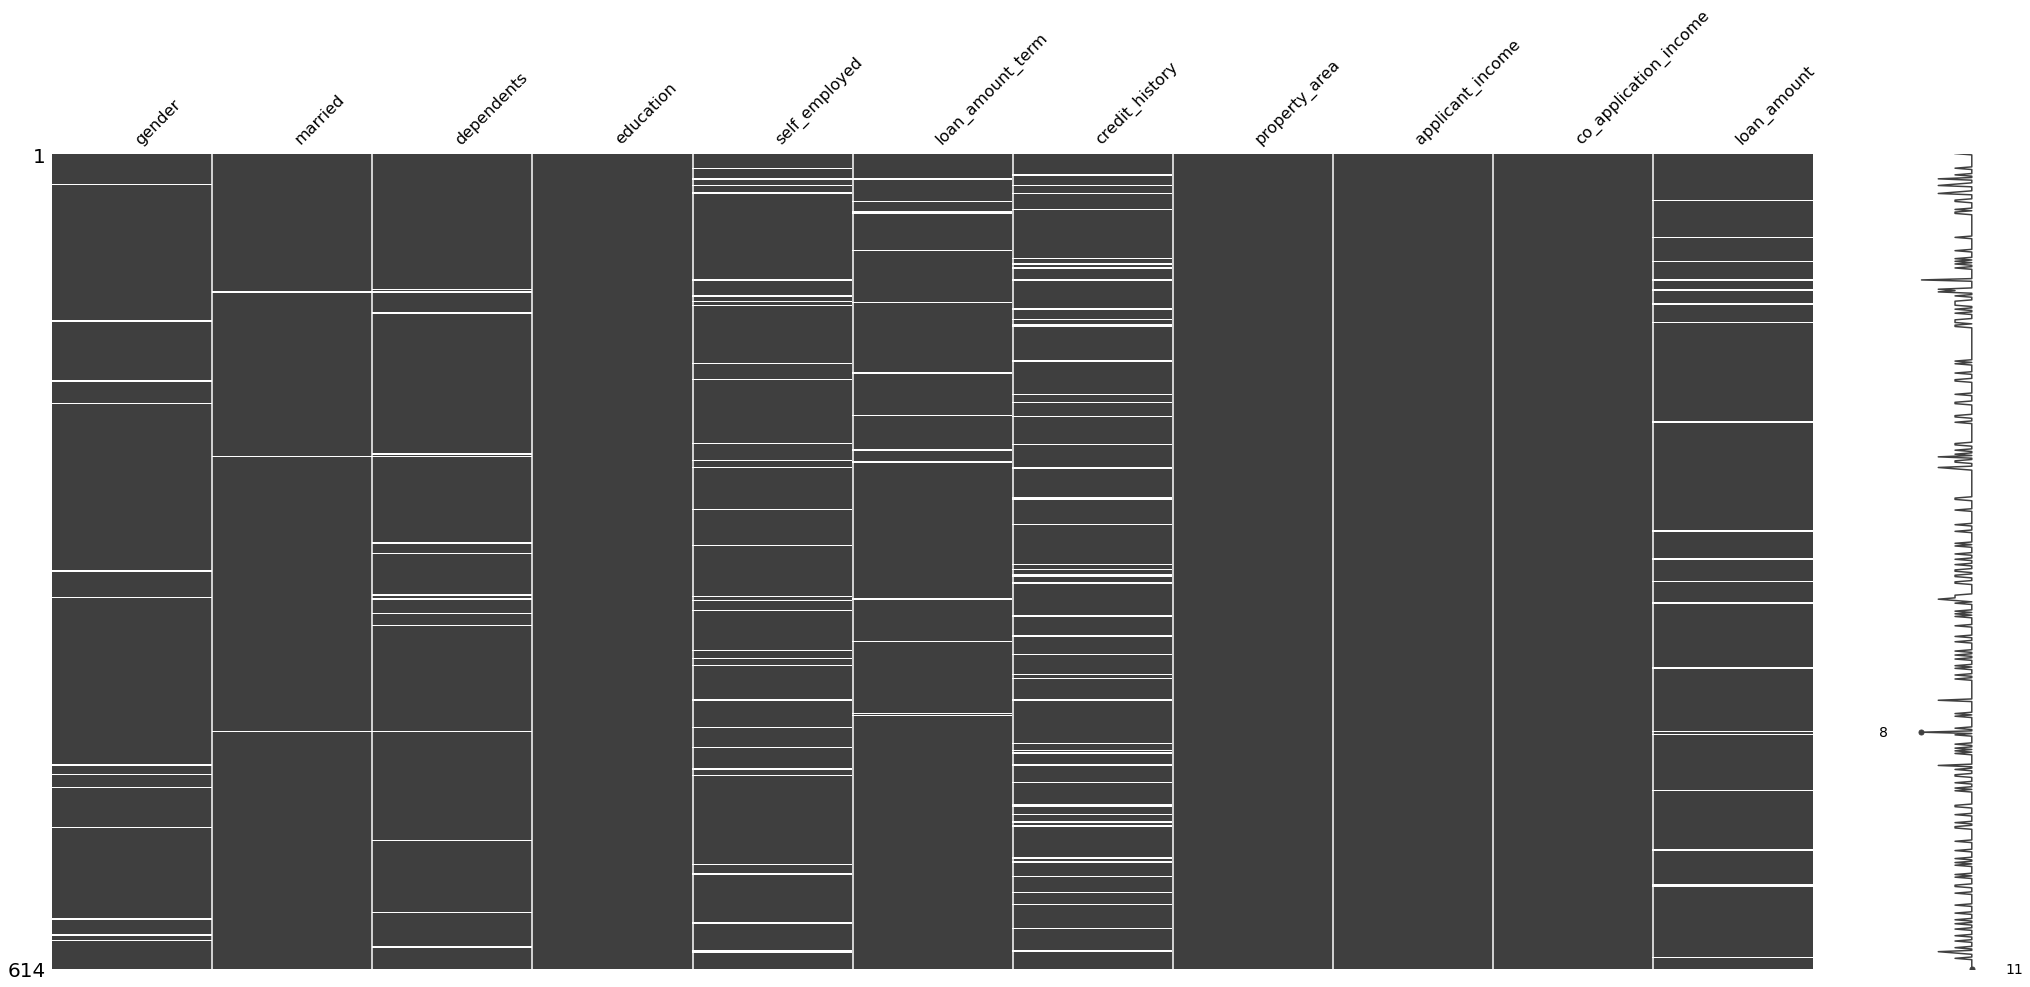

In [327]:
msno.matrix(df[feature_columns], figsize=(35, 15))

Looking closer, it can be observed `credit_history` column have lot of missing points, and the occurence of missingness is spread throughout the data and not at a given point in time.  

As touched upon earlier understanding the reasons behind missingness of data can help us choose the right technique to handle missing data. At a high level we can call these mechanisms of missing data and can classify these in three categories

MCAR - Missing completely at random
MNAR - Missing not at random
MAR - Missing at random


A data is (missing completely at random) when the likelihood of missing is the same for all the observations, and there is no relationship between the data missing and any other features in the dataset. For example a mail questionnaire might get lost in post or a person may have forgotten to answer a question if they were in a hurry. In such cases data being missing has nothing to do with type of question or age group or gender (relationship with other variables), and we can clasify such features or data points as MCAR. Removing these data points or changing the value to 0 for such instances will not bias the prediction.

On the other hand data is (missing at random), when likelihood of a data point being missing depends on other existing data points. For instance if men on average don't disclose their weight 5% of the time, where as women don't disclose their weight 15% of the time, we can assume that missingness in data is caused by presence of gender bias. This will lead to higher percent of data missing for women than men. For this mechanism we can impute data using statistical techniques or use machine learning to predict the missing value by utilising other features in the dataset, except the outcome.

The third mechanism (Missing data not at random) can often be confused with (Missing data at random), but is slightly different. In this scenario there can be a clear assumption made why data is not missing at random. For instance when we are trying to undrestand what factors lead to depression(outcome), depressed people are more likely to not answer questions or are less likely to be contacted. Since missingness is related to the outcome, these missing records can be flagged as "Missing" and for numerical features, we can use a combination of machine learning to impute missing data from other features and flag data points where data is missing by creating another variable.

Correlation heatmap measures nullity correlation between columns of the dataset. It shows how strongly the presence or absence of one feature affects the other.

Nullity correlation ranges from(-1 to 1):

- -1 means if one column(attribute) is present, the other is almost certainly absent.
- 0 means there is no dependence between the columns(attributes).
- 1 means if one column(attributes) is present, the other is also certainly present.
Unlike in a familiar correlation heatmap, if you see here, many columns are missing. Those columns which are always full or always empty have no meaningful correlation and are removed from the visualization.

The heatmap is helpful for identifying data completeness correlations between attribute pairs, but it has the limited explanatory ability for broader relationships and no special support for really big datasets.

<AxesSubplot:>

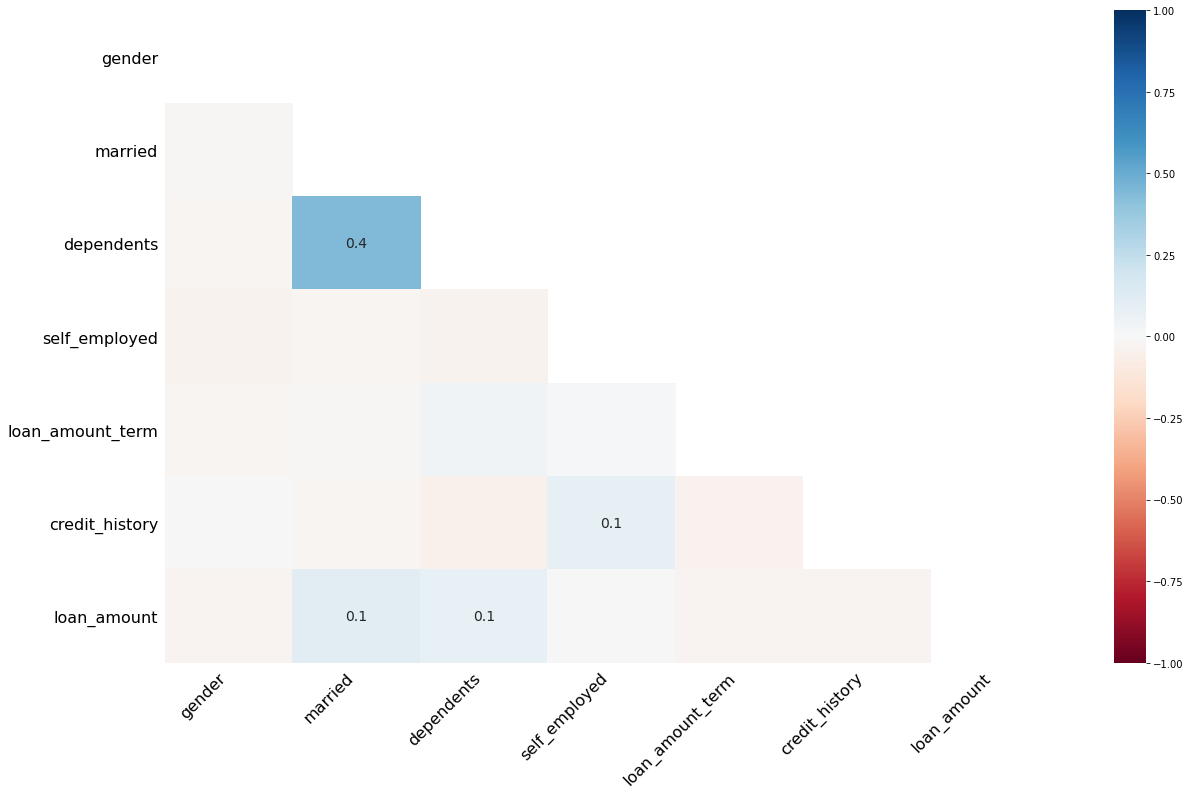

In [328]:
msno.heatmap(df[feature_columns], labels=True)

From the above plot we can interpret relationships of missingness across few variables. There is a corralation of 0.4 between `dependents` and `married`, which makes sense as majority of times someone gets married first before having dependents. 

In [329]:
# Lets check where columns with missing data are related to eech other
missing_columns = [cols for cols in feature_columns if df[cols].isnull().sum() > 0]
missing_columns

['gender',
 'married',
 'dependents',
 'self_employed',
 'loan_amount_term',
 'credit_history',
 'loan_amount']

<AxesSubplot:>

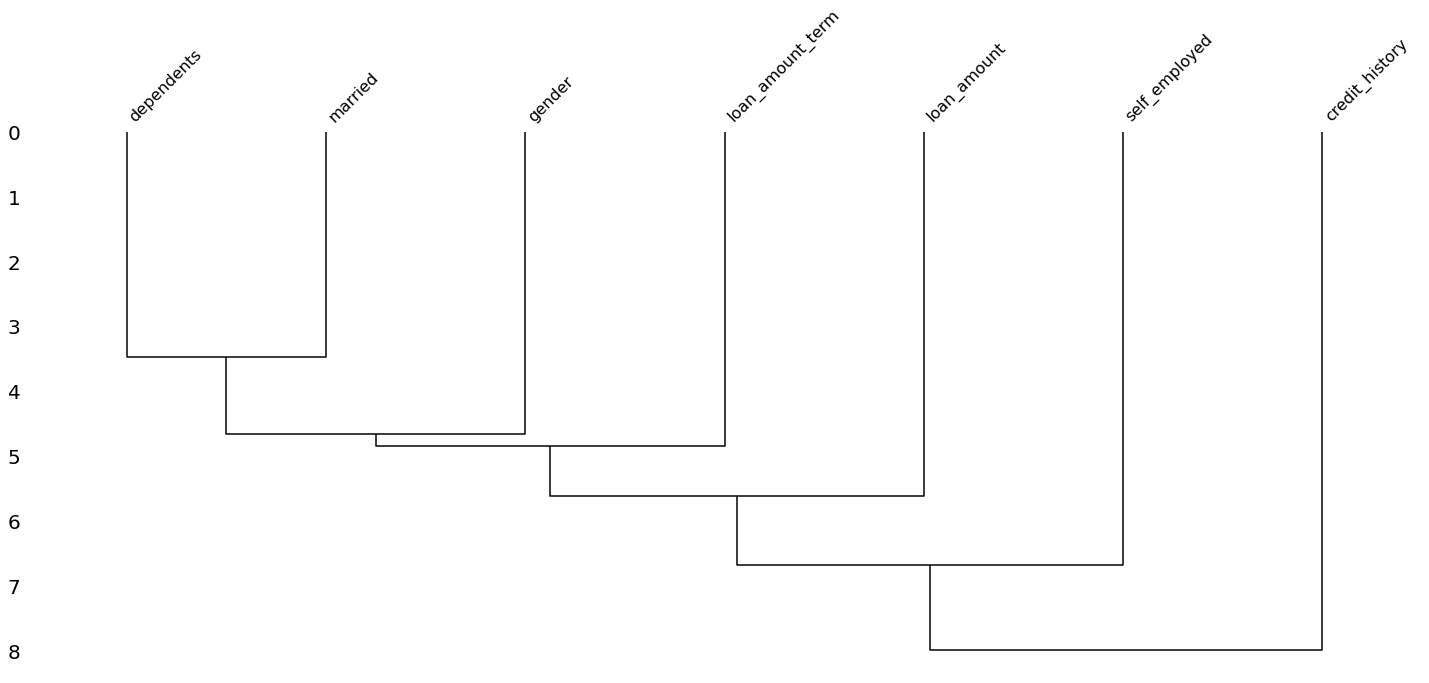

In [330]:
msno.dendrogram(df[missing_columns])

The dendogram method uses hierarchical clustering, and groups attributes together where missingness is associated with missingness of another variable or completeness is associated with completeness of another variable. We interpret the dendrogram based on a top-down approach, i.e., to focus on the height at which any two columns are connected together with matters of nullity. More the height, less will be the relation and vice versa is also True. For example missingness or presence of data in `credit_history` have no relationship with missingness or completeness of any other variable.

Before deciding to remove missing data or impute it, we should also look at whether missingness of variable is associated with outcome i.e. is there a chance that data may not be missing at random (MNAR).

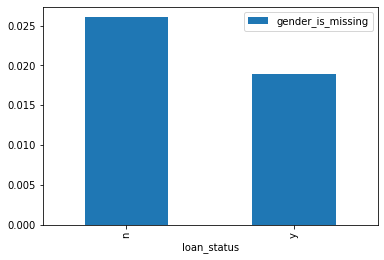

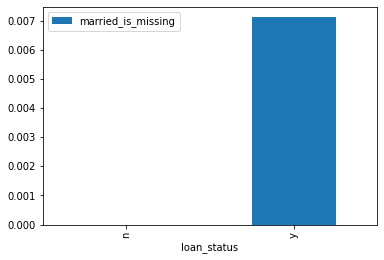

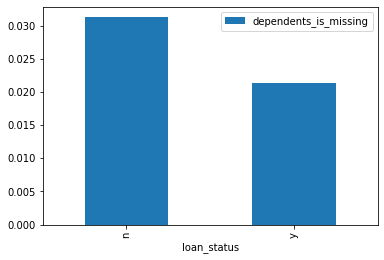

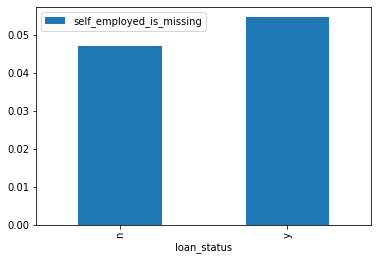

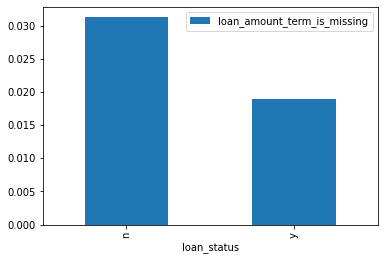

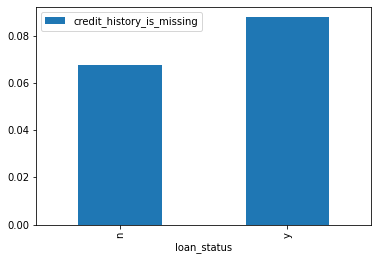

In [331]:
# Lets examine the missing categorical columns
cat_missing = [cols for cols in cat_columns if df[cols].isnull().sum() > 0]

def cat_missing_association_with_outcome(data, missing_data_column, outcome):
    """Function to plot missing association of categorical varibles with outcome"""
    
    df = data.copy()
    df[f"{missing_data_column}_is_missing"] = df[missing_data_column].isnull().astype(int)
    df.groupby([outcome]).agg({f"{missing_data_column}_is_missing": 'mean'}).plot.bar()
    
for cols in cat_missing:
    cat_missing_association_with_outcome(df, cols, target)

At a high level we can assume that for variables such as `married` and `dependents` missingness of data is associated with loan approved status. Hence we can say data for these variables is missing not at random. For these two variables we can encode missing data with word "missing" as this signal will help predict the outcome. The missingness or completeness of these two variables is also assocaited with each other as noticed in the heatmap plot, which indicates data might be missing at random, and we can use these variables to impute missing data

For other categorical variables we can assume data is not compeltely missing at random (MCAR), rather assume that data is not missing at random (NMAR), as there was some relationship of missingness of information with the outcome, or missing at random(MAR), since missingness is associated with presence or absence of other variables as noticed in dendogram. For remaining categorical variables we could encode them with most frequent values or get rid of missing values or/and create additional column that indicates missingness with 1 or 0. However for MAR scenario is not the best technique. As we recall earlier goal of DCAI is to improve the goodness of data and reduce bias in data. By using frequency imputation methods or just deleting records, we should consider to ask annotators to provide information where its missing and make system fixes to recover from missing information. If that is not possible, we should consider using machine learning techniques or probalistic techniques to determine possible value over simple imputation methods of mode , mean and median. However, when missingness exceeds certain thresholds, even advanced techniques are not reliable and its better to drop the feature.
For the remaining variables we shall use machine learning technique to determine the missing values, since we cannot get annotators to help us provide complete information

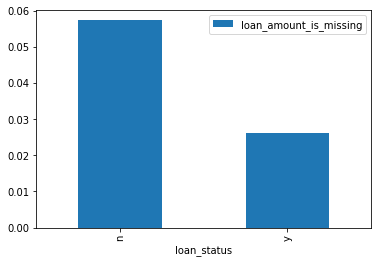

In [332]:
# Lets examine the missing numerical columns
num_missing = [cols for cols in missing_columns if cols not in cat_missing]

def num_missing_association_with_outcome(data, missing_data_column, outcome):
    """Function to plot missing association of categorical varibles with outcome"""
    
    df = data.copy()
    df[f"{missing_data_column}_is_missing"] = df[missing_data_column].isnull().astype(int)
    df.groupby([outcome]).agg({f"{missing_data_column}_is_missing": 'mean'}).plot.bar()


for cols in num_missing:
    num_missing_association_with_outcome(df, cols, target)

For all missing numerical columns it can be assumed that data is missing not at random (MNAR). Hence we shall conisder imputing missing values using machine learning as well as create additional column to indicate missingness, which shall further provide a better signal to our model

In model centric approach standard rule of thumb for imputing numerical variables is when 5% of data is missing, imputing them with mean, median or mode. This approach makes an assumption that data is missing completely at random, and if applied without thought analysis, may obscure the distribution of the data and relationship with other variables (if data was missing at random or missing not at random)

<AxesSubplot:ylabel='Density'>

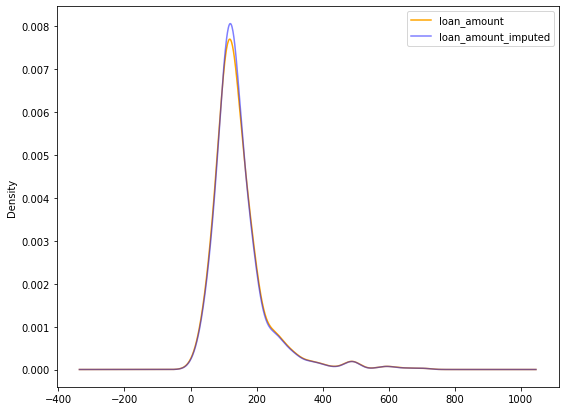

In [333]:
# Lets check the distribution of loan_amount and when imputed with median. The distribution has changed when we impute 6% of the values with median
df.loan_amount.plot.kde(color='orange', label='loan_amount', legend=True)
df.loan_amount.fillna(value=df.loan_amount.median()).plot.kde(color='b', label='loan_amount_imputed', alpha=0.5, figsize=(9,7), legend=True)

In [334]:
# The standard deviation has changed by $1K, and hence median imputation may not be the ideal method for imputing data with data centric approach
round(df.loan_amount.std(),2), round(df.loan_amount.fillna(value=df.loan_amount.median()).std(),2)

(85.59, 84.11)

To counter the above affects and preserve the distribution we can use random sample imputation method. We will first extract all the rows where `loan_amount` is missing. We will then compute the variables that are correlated with `loan_amount` and use the values for these to set a seed. This is because, if we use the same seed for all values, then a same random number will be generated and the method become arbitrary value imputation, which will be as ineffective as mean/median imputation.
The downside to random sample distribution is that covriance will be affected and we need a method that preserves the covariance as well.
Lets apply the random sample distribution on income variable and compare the distribution and covariance

In [335]:
num_columns

['applicant_income', 'co_application_income', 'loan_amount']

In [336]:
# Extracting where income is missing 
observation = df[df.loan_amount.isnull()]

# Computing correlation matrix
df[num_columns].corr()

,applicant_income,co_application_income,loan_amount
applicant_income,1.000000,-0.116605,0.570909
co_application_income,-0.116605,1.000000,0.188619
loan_amount,0.570909,0.188619,1.000000


`loan_amount` is highly correlated with `applicant_income`, and for the example we shall use those to set the seed

In [337]:
# Imputing the data using random sample technique
imputed_values = []
for idx in observation.index:
    seed = int(observation.loc[idx,['applicant_income']])
    imputed_value = df['loan_amount'].dropna().sample(1, random_state=seed)
    imputed_values.append(imputed_value)

# Creating a new variable and filling it with data so we can compare the effects

# Adding imputed data to missing rows
df.loc[df['loan_amount'].isnull(),'loan_amount_random_imputed']=imputed_values 

# Adding remaining data to the remaining rows, else rest of rows will show nan
df.loc[df['loan_amount'].isnull()==False,'loan_amount_random_imputed']=df[df['loan_amount'].isnull()==False]['loan_amount'].values
        

<AxesSubplot:ylabel='Density'>

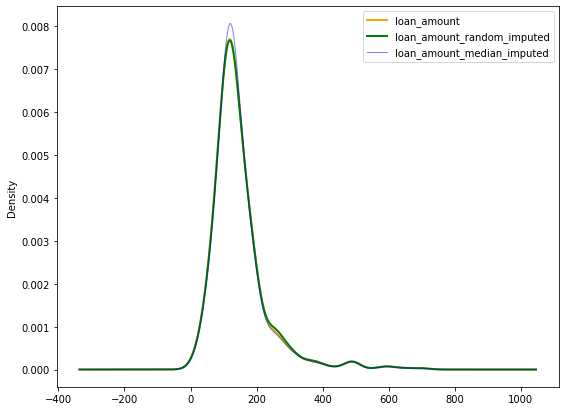

In [338]:
#Lets check the distribution of loan_amount and when imputed with random generator method
df.loan_amount.plot.kde(color='orange', label='loan_amount', legend=True, linewidth=2)
df.loan_amount_random_imputed.plot.kde(color='g', label='loan_amount_random_imputed', legend=True, linewidth=2)
df.loan_amount.fillna(value=df.loan_amount.median()).plot.kde(color='b', label='loan_amount_median_imputed', linewidth=1, alpha=0.5, figsize=(9,7), legend=True)

In [339]:
# After using the random generation method we can see the distributions are much more closer based on std when compared to median imputation
round(df.loan_amount.std(),2), round(df.loan_amount_random_imputed.std(),2)

(85.59, 85.57)

In [340]:
# However random sample distribution may distrupt the covariance
df['loan_amount_median_imputed'] = df['loan_amount'].fillna(value=df['loan_amount'].median())
df[['loan_amount', 'loan_amount_median_imputed','loan_amount_random_imputed', 'applicant_income']].corr()


,loan_amount,loan_amount_median_imputed,loan_amount_random_imputed,applicant_income
loan_amount,1.000000,1.000000,1.000000,0.570909
loan_amount_median_imputed,1.000000,1.000000,0.979281,0.565181
loan_amount_random_imputed,1.000000,0.979281,1.000000,0.561845
applicant_income,0.570909,0.565181,0.561845,1.000000


In [341]:
# Creating a dataset with just numerical columns
df_num = df[num_columns].copy()
df_num.columns

Index(['applicant_income', 'co_application_income', 'loan_amount'], dtype='object')

Another technique to impute data is referred as MICE (Multiple Imputation by Chained Equations). The way MICE works under the hood, is that at first all data is imputed with mean, median or mode. Then the variable that will be imputed, the initial imputated values are converted back to missing, and then using other variables as predictors, a machine learning model is used to predict missing values. Then the next variable is imputed in a similar manner where initially imputed values are converted back to missing, and other variables including the recently imputed variable are used as predictors to impute the missing values. Once all the variables with missing values are modeled and values have been imputed with predictions, the first round of imputation is completed. This procedure is repeated n number of times (ideally 10), and from round two round one predictions are used to predict records which were initially missing.

The reason for using several rounds is that initially we are modelling the missing data using other variables which themselves have NA, and initial strategy of imputation uses suboptimal methods like mean, median or mode, which may bias the predictions. As we continue to regress over multiple rounds, predictions will stabalise and become less biased.

One issue with MICE is that we have to choose which machine learning model to use for the task. 
We will implement MICE with Random Forest Algorithm, and to counter affects of choosing an algorithm, we will leverage automated machine learning, where for each imputation and iteration a new algorithm will be chosen

In [342]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [348]:
# Now the dataset is scaled and all variables have a z score
df_num.head()

,applicant_income,co_application_income,loan_amount
0,5849,0.0,NaN
1,4583,1508.0,128.0
2,3000,0.0,66.0
3,2583,2358.0,120.0
4,6000,0.0,141.0


In [349]:
# Bulding the Random forest imputation framework
random_forest_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1),
                           max_iter=10,
                           random_state=0)
# Imputing 
df_imputed = random_forest_imputer.fit_transform(df_num)

In [350]:
# Reverse transformation to get back the original values
df_imputed = pd.DataFrame(columns=num_columns, data=df_imputed)
df_imputed.head()

,applicant_income,co_application_income,loan_amount
0,5849.0,0.0,140.883548
1,4583.0,1508.0,128.000000
2,3000.0,0.0,66.000000
3,2583.0,2358.0,120.000000
4,6000.0,0.0,141.000000


<AxesSubplot:ylabel='Density'>

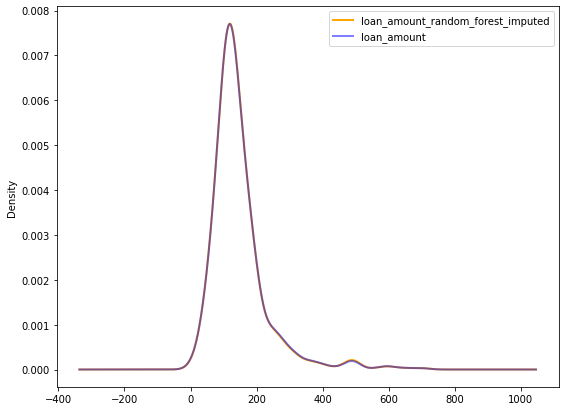

In [351]:
# Lets check the distribution of original and compare with the ml imputed
df_imputed['loan_amount'].plot.kde(color='orange', label='loan_amount_random_forest_imputed',linewidth=2, legend=True)
df['loan_amount'].plot.kde(color='b', label='loan_amount', legend=True, linewidth=2, figsize=(9,7), alpha=0.5)

In [352]:
# Lets compare the standard deviations
round(df.loan_amount.std(),2), round(df.loan_amount_random_imputed.std(),2), round(df_imputed.loan_amount.std(),2)

(85.59, 85.57, 85.64)

In [353]:
# Lets check the correlation with other variables
df['loan_amount_random_forest_imputed'] = df_imputed.loan_amount
df[['loan_amount', 'loan_amount_median_imputed','loan_amount_random_imputed', 'loan_amount_random_forest_imputed', 'applicant_income']].corr()

,loan_amount,loan_amount_median_imputed,loan_amount_random_imputed,loan_amount_random_forest_imputed,applicant_income
loan_amount,1.000000,1.000000,1.000000,1.000000,0.570909
loan_amount_median_imputed,1.000000,1.000000,0.979281,0.980776,0.565181
loan_amount_random_imputed,1.000000,0.979281,1.000000,0.970306,0.561845
loan_amount_random_forest_imputed,1.000000,0.980776,0.970306,1.000000,0.579463
applicant_income,0.570909,0.565181,0.561845,0.579463,1.000000


The standard deviation is slightly below random imputation however, it can be observed the correlation with the `application_income` is better and closer, when compared to random imputation method. Hence MICE is a better method than median imputation as standard deviation and overall distribution is preserved, as well as less impact on correlation with other variables

In [354]:
# We can drop the columns with imputed suffix since we used these to illustrate the effects of different imputation methods
df.drop(['loan_amount_median_imputed','loan_amount_random_imputed', 'loan_amount_random_forest_imputed'], axis=1, inplace=True)

In [355]:
# Now its time to impute Categorical variables, and we will combine this with numerical data imputation

In [276]:
from sklearn.preprocessing import LabelEncoder

In [356]:
df_temp = df.copy()
lb = LabelEncoder()

# Only encoding columns that don't have a numerical value
cat_cols_string_encoded = cat_columns

# Extracting the classes to which each value of a column will be encoded to
label_encoder_mapping = {}
for cols in cat_cols_string_encoded:
    classes = df_temp[cols].unique()
    classes = list(np.sort(classes[~pd.isna(classes)]))
    label_encoder_mapping[cols] = classes

    
# The label encoder under the hood will encode values from 0 to n-1 (n being number of unique values in the column)
# The encoder out of the box does not provide the encoded mappings
# We need these, post imputation to return the categorical variable to its original value
for key, val in label_encoder_mapping.items():
    index = 0
    val_mapping = {}
    for value in val:
        val_mapping[index] = value
        index += 1
    label_encoder_mapping[key] = val_mapping
    
# Encoding the data
df_temp[cat_cols_string_encoded] = df_temp[cat_cols_string_encoded].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))

In [357]:
# Getting the ordinal columns as we dont need to label encode these. Filtering the year column since its values are constant
ordinal_columns = [cols for cols in df_temp if cols not in cat_cols_string_encoded + num_columns + [id_col, target]]

# Combining the columns as it is recommended use all the data to impute with MICE framework
columns = [cols for cols in cat_cols_string_encoded + ordinal_columns + num_columns]

In [358]:
# Creating a temp dataframe and running Mice
df_temp_ = df_temp[columns].copy()

# Bulding the Random forest imputation framework for categorical variables
rf_imp = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=0, bootstrap=True, n_jobs=-1),
                           max_iter=20,
                           random_state=0)
# Imputing 
df_imputed = rf_imp.fit_transform(df_temp_)

In [359]:
# Unscaling the values to get back the original values
df_imputed_ = pd.DataFrame(columns=columns, data=df_imputed)

# converting to int, as since mappings are tied to integers
df_imputed_[cat_cols_string_encoded + ordinal_columns] = df_imputed_[cat_cols_string_encoded+ordinal_columns].astype('int')

# Remapping to the original categorical values
for key, val in label_encoder_mapping.items():
    df_imputed_[key] = df_imputed_[key].map(val)

In [360]:
# Lets check whether the values have been imputed
df_imputed_.isnull().sum()

gender                   0
married                  0
dependents               0
education                0
self_employed            0
loan_amount_term         0
credit_history           0
property_area            0
applicant_income         0
co_application_income    0
loan_amount              0
dtype: int64

We can now use the above steps and make it into Scikit learn pipeline, as using a pipeline we can define the sequence of steps, and also save these steps as a pickle object. By utilising this practice we maintain machine learning system best practices, and can ensure reliability and reproucability, without replicating the code in the inference setting.

In [285]:
# Now we have imputed the data lets bring it all together and ensure all the values are imputed
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from typing import List
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer

In [426]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns],df[target].map({'y':1, 'n':0}) , test_size=0.1, random_state=0, stratify=df[target].map({'y':1, 'n':0}))

Encoding the categorical variables into rare labels if they dont meet threshold, i.e. if the cardinality is too low, i.e. where a category makes 1 percent of the feature values. This ensures that training data sees
the rare values and model is not overfiltted, and is generalised.
We fill first impute the missing data using Mice technique and then check for rare labels

In [427]:
for cols in cat_cols_string_encoded:
    print(cols)
    print(df[cols].value_counts(normalize=True))
    print()

gender
male      0.813644
female    0.186356
Name: gender, dtype: float64

married
yes    0.651391
no     0.348609
Name: married, dtype: float64

dependents
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: dependents, dtype: float64

education
graduate        0.781759
not_graduate    0.218241
Name: education, dtype: float64

self_employed
no     0.859107
yes    0.140893
Name: self_employed, dtype: float64

loan_amount_term
month_30    0.853333
month_15    0.073333
month_40    0.025000
month_25    0.021667
month_20    0.006667
month_7     0.006667
month_10    0.005000
month_3     0.003333
month_5     0.003333
month_1     0.001667
Name: loan_amount_term, dtype: float64

credit_history
yes    0.842199
no     0.157801
Name: credit_history, dtype: float64

property_area
semi_urban    0.379479
urban         0.328990
rural         0.291531
Name: property_area, dtype: float64



In [428]:
def cat_encoder_mapping(df: pd.DataFrame, columns: List[str]) -> dict:
    """Function is a helper function for label encoder and builds a mapping for categorical variables
       The function returns the mapping so encoded variables can be decoded to original form"""
    
    
    # Extracting the classes to which each value of a column will be encoded to
    label_encoder_mapping = {}
    for cols in columns:
        classes = df[cols].unique()
        classes = list(np.sort(classes[~pd.isna(classes)])) #exluding na's from the list
        label_encoder_mapping[cols] = classes


    # The label encoder under the hood will encode values from 0 to n-1 (n being number of unique values in the column)
    # The encoder out of the box does not provide the encoded mappings
    # We need these, post imputation to return the categorical variable to its original value
    for key, val in label_encoder_mapping.items():
        index = 0
        val_mapping = {}
        for value in val:
            val_mapping[index] = value
            index += 1
        label_encoder_mapping[key] = val_mapping
        
    return label_encoder_mapping


class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    """Class to bulk encode categorical variables"""
    
    def __init__(self, cat_columns: List[str]):
        """Constructor"""
        
        self.cat_columns = cat_columns
        self.label_encoder_mapping = {}
    
    def fit(self, X, y=None):
        """Custom fit function"""
        
        self.label_encoder_mapping = cat_encoder_mapping(df=X, columns=self.cat_columns)
        return self
    
    def transform(self, X, y=None):
        """Custom transformer"""
        
        # Encoding the data
        X = X.copy()
        X[self.cat_columns] = X[self.cat_columns]\
                              .apply(lambda series: pd.Series(
                                      LabelEncoder().fit_transform(series[series.notnull()])
                                     ,index=series[series.notnull()].index)
                                    )
        return X
    

class CustomLabelDecoder(BaseEstimator, TransformerMixin):
    """Class to decode the categorical columns based on mapping object"""
    
    def __init__(self, features: List[str], label_encoder_mapping: dict):
        """Constructor"""
        
        self.label_encoder_mapping = label_encoder_mapping
        self.features = features
        self.X_ = pd.DataFrame()
        
    def fit(self, X, y=None):
        """Custom fit function"""
        
        return self
    
    def transform(self, X, y=None):
        """Custom transform method"""
        
        X = X.copy()
        
        self.X_ = pd.DataFrame(data=X, columns=self.features)
        
        for key, val in self.label_encoder_mapping.items():
            self.X_[key] = self.X_[key].astype(int)
            self.X_[key] = self.X_[key].map(val)
        
        return self.X_

In [429]:
# Running the encoder pipeline
encoder_pipeline = Pipeline(
    steps=[
        ('cat_encoding', 
          CustomLabelEncoder(cat_columns=cat_cols_string_encoded)
        )
    ]
)

X_train_encoded = encoder_pipeline.fit_transform(X_train)
X_test_encoded = encoder_pipeline.transform(X_test)

In [434]:
# Running the custom imputer pipeline as scikit learn pipeline and decoding the categories which were encoded into numerical form
custom_preprocessor = Pipeline(
    steps=[('mice_imputation',
           IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0, bootstrap=True, n_jobs=-1),
                           max_iter=20,
                           random_state=0)
           ),
           ('custom_label_decoder',
            CustomLabelDecoder(features=columns, 
                               label_encoder_mapping=encoder_pipeline.named_steps['cat_encoding'].label_encoder_mapping)),
           ('rare_label_encoder', 
            RareLabelEncoder(tol=0.02, n_categories=8, variables=cat_cols_string_encoded, replace_with='rare'))
           ]
)

custom_transformer = ColumnTransformer(transformers=
    [
        ("all_features", custom_preprocessor, columns)
    ]
)

custom_pipeline = Pipeline(
    steps=[(
        "custom_transformer", custom_transformer
    )]
)

X_train_imputed = custom_pipeline.fit_transform(X_train_encoded)
X_test_imputed = custom_pipeline.transform(X_test_encoded)

/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable married is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable dependents is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable education is less than that i

Once data is imputed then we can one hot encode categorical data and pass the numerical data as is. In python we can leverage DictVectorizor to do both, but first we may need to convert the data into dictionary. For that we will use `pandas.to_dict()` method

In [435]:
custom_pipeline.named_steps['custom_transformer'].transformers_[0][2]
X_train_dict = pd.DataFrame(data=X_train_imputed, columns=features).to_dict(orient='records')
X_test_dict = pd.DataFrame(data=X_test_imputed, columns=features).to_dict(orient='records')

In [436]:
# Apply the dictvectorizor to one hot encode
dv = DictVectorizer(sparse=False)
X_train_transformed = dv.fit_transform(X_train_dict)
X_test_transformed = dv.transform(X_test_dict)

In [437]:
pd.DataFrame(X_train_transformed, columns=dv.get_feature_names()).columns

Index(['applicant_income', 'co_application_income', 'credit_history=no',
       'credit_history=yes', 'dependents=0', 'dependents=1', 'dependents=2',
       'dependents=3+', 'education=graduate', 'education=not_graduate',
       'gender=female', 'gender=male', 'loan_amount',
       'loan_amount_term=month_15', 'loan_amount_term=month_25',
       'loan_amount_term=month_30', 'loan_amount_term=month_40',
       'loan_amount_term=rare', 'married=no', 'married=yes',
       'property_area=rural', 'property_area=semi_urban',
       'property_area=urban', 'self_employed=no', 'self_employed=yes'],
      dtype='object')

In [438]:
# Lets train the model and check the score. But before lets check the class imbalance. 
y_train.mean(), y_test.mean()

(0.6865942028985508, 0.6935483870967742)

Because classes are slightly imbalanced, we can use the `class_weight='balanced'` option, since this option uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data when training the algorithm

In [445]:
# Training the model using cross validation to ensure model is generalisable and can be used in a good setting
d_param_grid = {
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,20],
    'min_samples_leaf' : [1,3,5,10,15,20,25,30],
    'criterion' : ['gini', 'entropy'],
    'random_state' : [0], 
    'class_weight' : ['balanced', None]
}
d_clf = DecisionTreeClassifier()


# Training the models
d_clf_cv = GridSearchCV(estimator=d_clf, param_grid=d_param_grid, cv=5, scoring='roc_auc')
d_clf_cv.fit(X_train_transformed, y_train)

print("Decision tree optimised")


d_best_params = d_clf_cv.best_params_

print(f"Getting the best params which are {d_best_params}")

model = DecisionTreeClassifier(**d_best_params)
model.fit(X_train_transformed, y_train)

training_predictions_prob = model.predict_proba(X_train_transformed)
testing_predictions_prob = model.predict_proba(X_test_transformed)

training_predictions = model.predict(X_train_transformed)
testing_predictions = model.predict(X_test_transformed)

training_roc_auc = roc_auc_score(y_train, training_predictions_prob[:,1])
testing_roc_auc = roc_auc_score(y_test, testing_predictions_prob[:,1])

training_acc = accuracy_score(y_train, training_predictions)
testing_acc = accuracy_score(y_test, testing_predictions)

print(f"Training roc is {training_roc_auc}, and testing roc is {testing_roc_auc} \n \
        training accuracy is {training_acc}, testing_acc as {testing_acc}")

Decision tree optimised
Getting the best params which are {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'random_state': 0}
Training roc is 0.7597724465051016, and testing roc is 0.8182374541003672 
         training accuracy is 0.7336956521739131, testing_acc as 0.6290322580645161


In [381]:
pd.DataFrame(X_train_transformed, columns=dv.get_feature_names()).head()

,applicant_income,co_application_income,credit_history=no,credit_history=yes,dependents=0,dependents=1,dependents=2,dependents=3+,education=graduate,education=not_graduate,...,loan_amount_term=month_40,loan_amount_term=month_5,loan_amount_term=month_7,married=no,married=yes,property_area=rural,property_area=semi_urban,property_area=urban,self_employed=no,self_employed=yes
0,3500.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1782.0,2232.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,4384.0,1793.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,6125.0,1625.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1625.0,1803.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [134]:
# We can see both training and testing roc is high, i.e. model is generalisable and not overfitted or underfitted

Lets take a counter intuitive approach and check if we just used mean/median to impute the numerical variables, and imputed categorical variables with most frequent occurences, what results we shall get

In [446]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[feature_columns],df[target].map({'y':1, 'n':0}) , test_size=0.1, random_state=0, stratify=df[target].map({'y':1, 'n':0}))

In [447]:
X_train.head()

,gender,married,dependents,education,self_employed,loan_amount_term,credit_history,property_area,applicant_income,co_application_income,loan_amount
72,male,no,0,graduate,no,month_25,yes,semi_urban,3500,0.0,81.0
578,male,yes,1,graduate,no,month_30,yes,rural,1782,2232.0,107.0
330,male,no,1,graduate,no,month_30,yes,urban,4384,1793.0,117.0
573,male,yes,2,not_graduate,no,month_40,yes,semi_urban,6125,1625.0,187.0
303,male,yes,1,graduate,no,month_30,yes,urban,1625,1803.0,96.0


In [449]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_median", MeanMedianImputer(imputation_method='median', variables=num_missing)),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_frequent",
            CategoricalImputer(imputation_method='frequent', variables=cat_missing),
        ),
        (
            'rare_label_encoder', 
            RareLabelEncoder(tol=0.02, n_categories=8, variables=cat_cols_string_encoded, replace_with='rare')
        )
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_cols_string_encoded),
        ("numerical", numeric_preprocessor, num_columns + ordinal_columns),
    ]
)

preprocessor_pipeline = Pipeline(
    steps=[(
        'preprocessor', preprocessor
    )]
)

In [450]:
X_train_imputed = preprocessor_pipeline.fit_transform(X_train)
X_test_imputed = preprocessor_pipeline.transform(X_test)

/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable married is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable dependents is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/bajajn/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:157: UserWarning: The number of unique categories for variable education is less than that i

In [451]:
X_train_dict = pd.DataFrame(data=X_train_imputed, columns=features).to_dict(orient='records')
X_test_dict = pd.DataFrame(data=X_test_imputed, columns=features).to_dict(orient='records')

# Apply the dictvectorizor to one hot encode
dv = DictVectorizer(sparse=False)
X_train_transformed = dv.fit_transform(X_train_dict)
X_test_transformed = dv.transform(X_test_dict)

In [452]:
# Training the model using cross validation to ensure model is generalisable and can be used in a good setting
d_param_grid = {
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,20],
    'min_samples_leaf' : [1,3,5,10,15,20,25,30],
    'criterion' : ['gini', 'entropy'],
    'random_state' : [0], 
    'class_weight' : ['balanced', None]
}
d_clf = DecisionTreeClassifier()


# Training the models
d_clf_cv = GridSearchCV(estimator=d_clf, param_grid=d_param_grid, cv=5, scoring='roc_auc')
d_clf_cv.fit(X_train_transformed, y_train)

print("Decision tree optimised")


d_best_params = d_clf_cv.best_params_

print(f"Getting the best params which are {d_best_params}")

model = DecisionTreeClassifier(**d_best_params)
model.fit(X_train_transformed, y_train)

training_predictions_prob = model.predict_proba(X_train_transformed)
testing_predictions_prob = model.predict_proba(X_test_transformed)

training_predictions = model.predict(X_train_transformed)
testing_predictions = model.predict(X_test_transformed)

training_roc_auc = roc_auc_score(y_train, training_predictions_prob[:,1])
testing_roc_auc = roc_auc_score(y_test, testing_predictions_prob[:,1])

training_acc = accuracy_score(y_train, training_predictions)
testing_acc = accuracy_score(y_test, testing_predictions)

print(f"Training roc is {training_roc_auc}, and testing roc is {testing_roc_auc} \n \
        training accuracy is {training_acc}, testing_acc as {testing_acc}")

Decision tree optimised
Getting the best params which are {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'random_state': 0}
Training roc is 0.7781658456235607, and testing roc is 0.769889840881273 
         training accuracy is 0.7590579710144928, testing_acc as 0.6612903225806451


In [453]:
dv.get_feature_names()

['applicant_income',
 'co_application_income',
 'credit_history=no',
 'credit_history=yes',
 'dependents=0',
 'dependents=1',
 'dependents=2',
 'dependents=3+',
 'education=graduate',
 'education=not_graduate',
 'gender=female',
 'gender=male',
 'loan_amount',
 'loan_amount_term=month_15',
 'loan_amount_term=month_25',
 'loan_amount_term=month_30',
 'loan_amount_term=month_40',
 'loan_amount_term=rare',
 'married=no',
 'married=yes',
 'property_area=rural',
 'property_area=semi_urban',
 'property_area=urban',
 'self_employed=no',
 'self_employed=yes']